# Redes Neuronales Recurrentes

### Laboratorio 4

En este laboratorio haremos un ejercicio de Redes Neuronales Recurrentes `RNN` para predecir la temperatura de Alemania.

In [1]:
# librerias a utilizar en el notebook
import numpy as np # libreria para manejo de vectores y matrices
import pandas as pd # libreria para manejo de dataframes

### Dataset

Jena Climate es un conjunto de datos de series temporales meteorológicas registrados en la estación meteorológica del Instituto Max Planck de Biogeoquímica en Jena, Alemania.

El conjunto de datos climáticos de Jena se compone de 14 cantidades diferentes (como la temperatura del aire, la presión atmosférica, la humedad, la dirección del viento, etc.) que se registraron cada 10 minutos durante varios años. Este conjunto de datos cubre datos desde el 1 de enero de 2009 al 31 de diciembre de 2016. Para este laboratorio, utilizaremos solo los datos de temperatura.

Link: https://www.kaggle.com/stytch16/jena-climate-2009-2016

In [18]:
# cargamos el dataset csv
df = pd.read_csv('jena_climate_2009_2016.csv')
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


In [19]:
# agarramos la col "T (degC)"" que es la temperatura en grados centigrados
data = df['T (degC)'].values
data.shape

(420551,)

In [20]:
# Definir la longitud de las secuencias
longitud_secuencia = 60

# Calcular el número de secuencias completas que se pueden formar
num_secuencias = len(data) // longitud_secuencia

# Inicializar listas vacías para almacenar X e Y
series = []

# Crear las secuencias de entrada (X) y sus correspondientes valores objetivo (Y)
for i in range(num_secuencias):
    secuencia = data[i * longitud_secuencia: (i + 1) * longitud_secuencia]
    series.append(secuencia)

# Convertir las listas en arrays de NumPy
series = np.array(series).astype(np.float32)

# Cambiar la forma de X a (número de secuencias, longitud de secuencia, número de características)
series = np.reshape(series, (series.shape[0], series.shape[1], 1))

# Verificar las dimensiones de X e Y
print("Dimensiones de series:", series.shape)

Dimensiones de series: (7009, 60, 1)


### Normalizamos

Para normalizar los datos, sacaremos el valor mayor y menor de la temperatura y lo normalizaremos entre -1 y 1.

In [21]:
# normalizar los datos de entrada y salida entre -1 y 1
# Valores mínimos y máximos en tu dataset original
min_valor = series.min()
max_valor = series.max()

# Rango al que quieres normalizar
rango_normalizado = (-1, 1)

# Normalizar el dataset
series_normalized = (series - min_valor) / (max_valor - min_valor) * (rango_normalizado[1] - rango_normalizado[0]) + rango_normalizado[0]

# Verificar los valores normalizados
print("Valores normalizados:", series_normalized.min(), series_normalized.max())
series = series_normalized

Valores normalizados: -1.0 1.0


### Clase TimeSeriesDataset

Esta clase nos ayudará a crear un dataset de series de tiempo.

In [22]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
  def __init__(self, X, y=None, train=True):
    self.X = X
    self.y = y
    self.train = train

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    if self.train:
      return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
    return torch.from_numpy(self.X[ix])

Separamos los datos en `train`, `valid` y `test` y luego creamos un dataset con los datos de `train`, `valid` y `test`. Posteriormente, creamos un dataloader para cada uno de los datasets.

In [23]:
# 7009
n_steps = 50
X_train, y_train = series[:4000, :n_steps], series[:4000, -10:, 0]
X_valid, y_valid = series[4000:6000, :n_steps], series[4000:6000, -10:, 0]
X_test, y_test = series[6000:, :n_steps], series[6000:, -10:, 0]

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

(4000, 50, 1) (4000, 10)
(2000, 50, 1) (2000, 10)
(1009, 50, 1) (1009, 10)


Metodo para graficar las series de tiempo. `plot_series.`

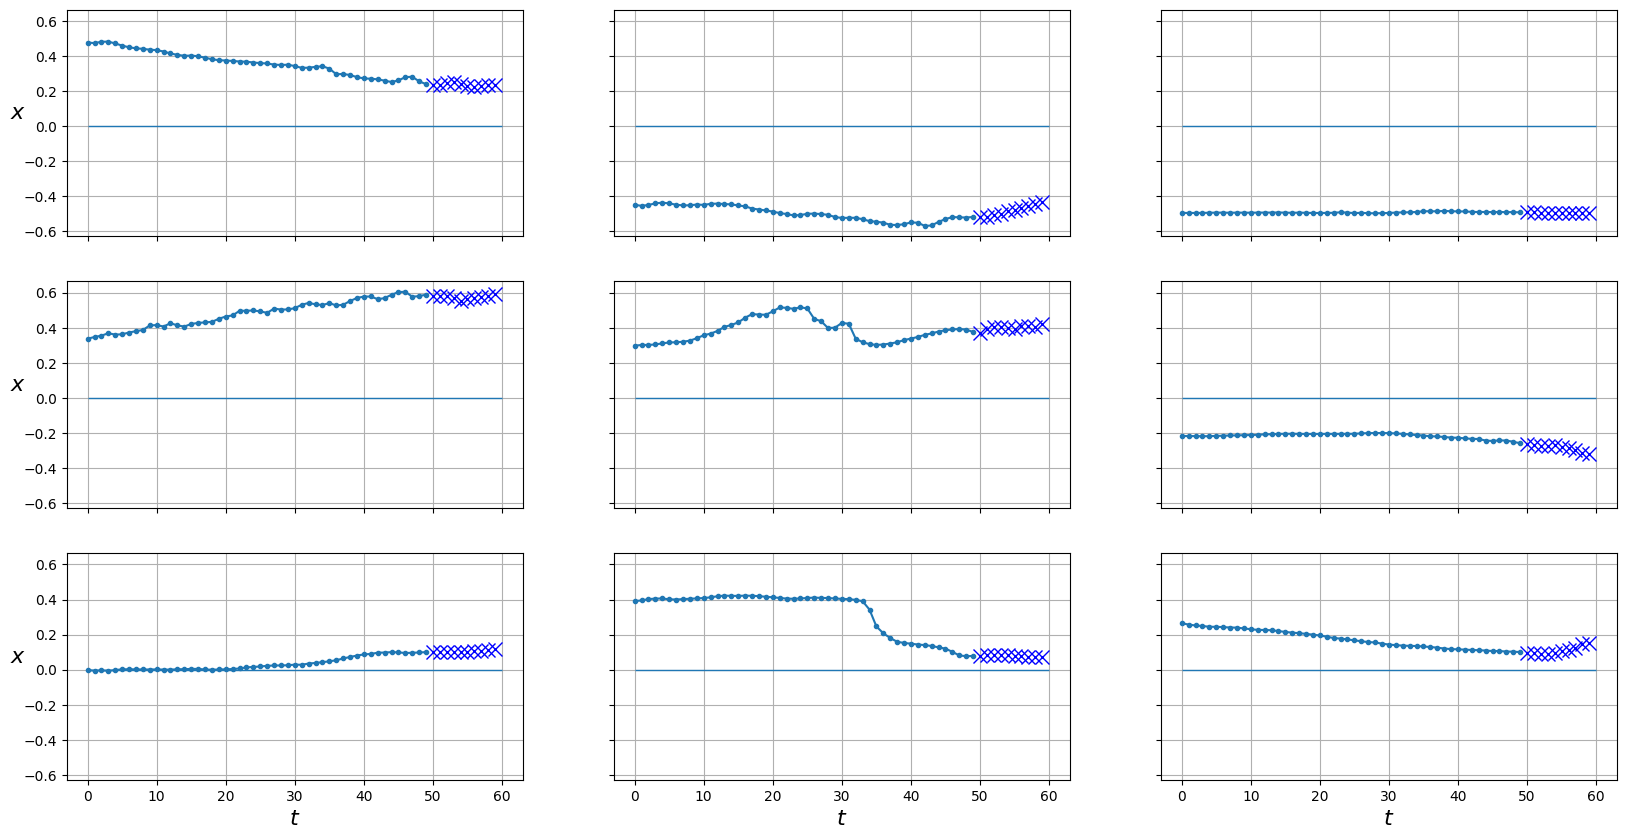

In [40]:
import numpy as np
import matplotlib.pyplot as plt

def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$", num_obs=60):
    r, c = 3, 3
    fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))

    # Generar un orden aleatorio para los ejemplos de entrenamiento
    num_examples = series.shape[0]
    random_order = np.random.permutation(num_examples)

    for row in range(r):
        for col in range(c):
            plt.sca(axes[row][col])
            ix = random_order[col + row*c]
            # Mostrar solo las últimas 'num_obs' observaciones
            last_obs = -num_obs if num_obs > 0 else None
            plt.plot(series[ix, last_obs:], ".-")
            if y is not None:
                plt.plot(range(len(series[ix, last_obs:]), len(series[ix, last_obs:])+len(y[ix])), y[ix], "bx", markersize=10)
            if y_pred is not None:
                plt.plot(range(len(series[ix, last_obs:]), len(series[ix, last_obs:])+len(y_pred[ix])), y_pred[ix], "ro")
            if y_pred_std is not None:
                plt.plot(range(len(series[ix, last_obs:]), len(series[ix, last_obs:])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
                plt.plot(range(len(series[ix, last_obs:]), len(series[ix, last_obs:])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
            plt.grid(True)
            plt.hlines(0, 0, num_obs, linewidth=1)
            #plt.axis([0, num_obs + len(y[ix]), -1, 1])
            if x_label and row == r - 1:
                plt.xlabel(x_label, fontsize=16)
            if y_label and col == 0:
                plt.ylabel(y_label, fontsize=16, rotation=0)

    plt.show()

plot_series(X_train, y_train)

### Modelo RNN



In [89]:
class DeepRNN(torch.nn.Module):
  def __init__(self, n_out=10):
    super().__init__()
    self.rnn = torch.nn.GRU(input_size=1, hidden_size=60, num_layers=2, batch_first=True)
    self.fc = torch.nn.Linear(60, n_out)

  def forward(self, x):
    x, h = self.rnn(x)
    x = self.fc(x[:,-1])
    return x

### Entrenamiento

La función `fit` nos ayudará a entrenar el modelo.

In [90]:
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    bar = tqdm(range(1, epochs+1))
    for epoch in bar:
        model.train()
        train_loss = []
        for batch in dataloader['train']:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        model.eval()
        eval_loss = []
        with torch.no_grad():
            for batch in dataloader['eval']:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
        bar.set_description(f"loss {np.mean(train_loss):.5f} val_loss {np.mean(eval_loss):.5f}")

# funcion para predecir los valores de la serie de tiempo con el modelo entrenado
def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [91]:
# instanciamos el modelo y lo entrenamos
rnn = DeepRNN()
fit(rnn, dataloader, epochs=30)

loss 0.00077 val_loss 0.00082: 100%|██████████| 30/30 [00:05<00:00,  5.41it/s]


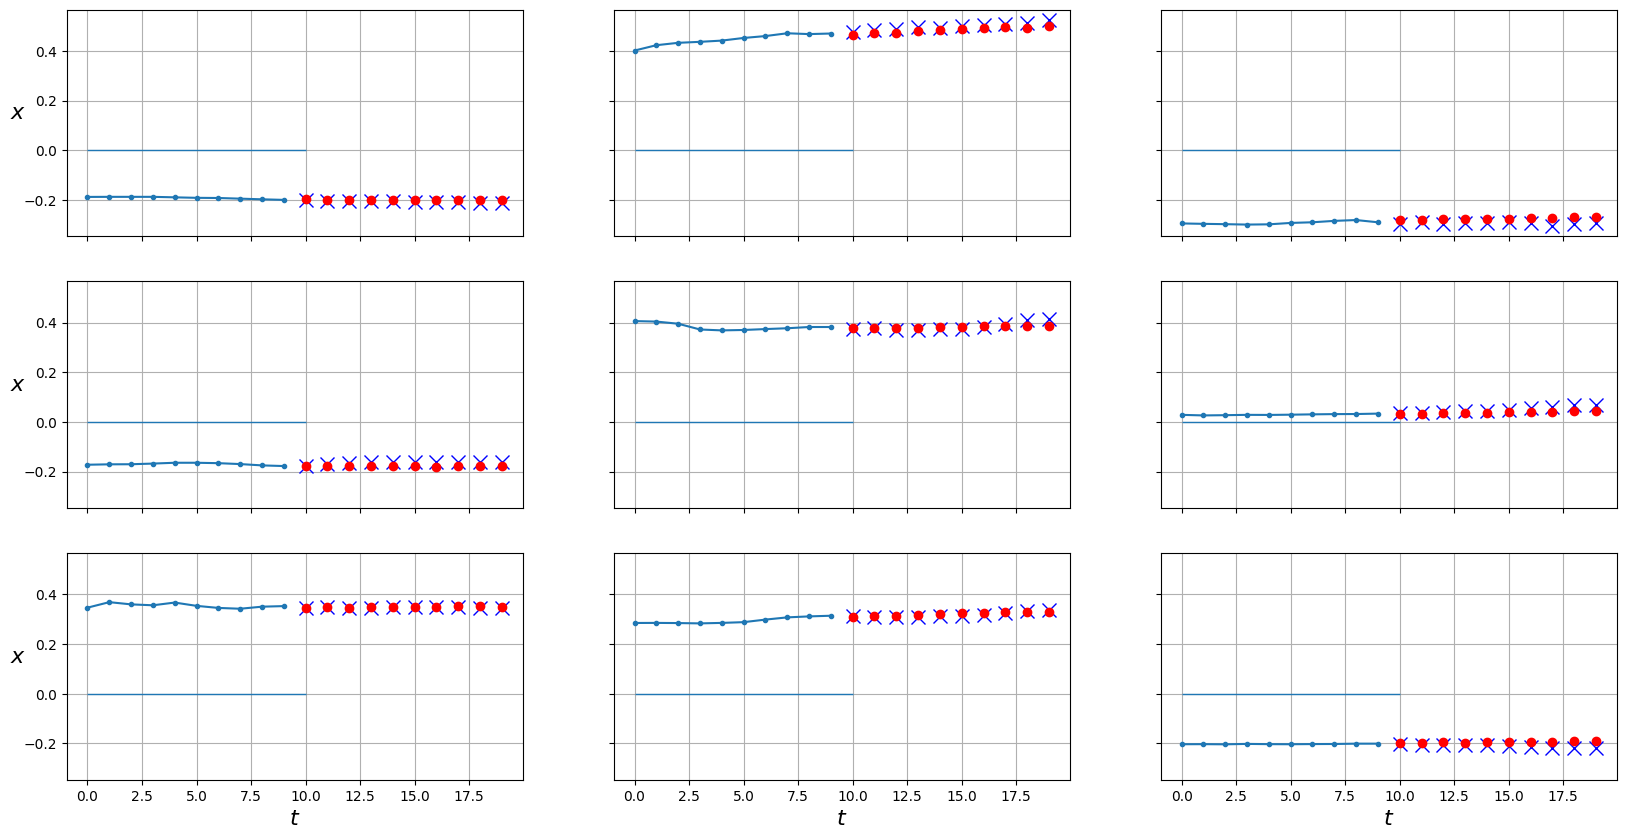

0.00068002084

In [97]:
# predecimos los valores de la serie de tiempo
from sklearn.metrics import mean_squared_error

y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy(), num_obs=10)
mean_squared_error(y_test, y_pred.cpu())